In [5]:
!pip install pystan
!pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 1.9 MB/s eta 0:00:00
ERROR: Operation cancelled by user


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


After running the above cell and following the authentication steps, your Google Drive will be mounted at `/content/drive`. You can then list the contents of your drive to find your files. For example, to list the contents of your root Google Drive folder:

In [8]:
df=pd.read_csv('/content/Tesla.csv')
df.describe()


,Open,High,Low,Close,Volume,Adj Close
count,1692.000000,1692.000000,1692.000000,1692.000000,1.692000e+03,1692.000000
mean,132.441572,134.769698,129.996223,132.428658,4.270741e+06,132.428658
std,94.309923,95.694914,92.855227,94.313187,4.295971e+06,94.313187
min,16.139999,16.629999,14.980000,15.800000,1.185000e+05,15.800000
25%,30.000000,30.650000,29.215000,29.884999,1.194350e+06,29.884999
50%,156.334999,162.370002,153.150002,158.160004,3.180700e+06,158.160004
75%,220.557495,224.099999,217.119999,220.022503,5.662100e+06,220.022503
max,287.670013,291.420013,280.399994,286.040009,3.716390e+07,286.040009


In [10]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1692 non-null   object 
 1   Open       1692 non-null   float64
 2   High       1692 non-null   float64
 3   Low        1692 non-null   float64
 4   Close      1692 non-null   float64
 5   Volume     1692 non-null   int64  
 6   Adj Close  1692 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 92.7+ KB


,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [11]:
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)


In [12]:
df = df.reset_index()
df=df.rename(columns={'Date':'ds','Open':'y'})
df['y_orig']=df['y']
df['y']=np.log(df['y'])
df.info()
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         1692 non-null   datetime64[ns]
 1   y          1692 non-null   float64       
 2   High       1692 non-null   float64       
 3   Low        1692 non-null   float64       
 4   Close      1692 non-null   float64       
 5   Volume     1692 non-null   int64         
 6   Adj Close  1692 non-null   float64       
 7   y_orig     1692 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 105.9 KB


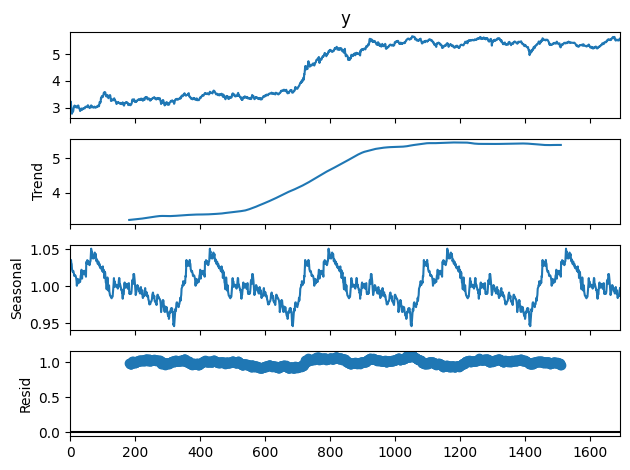

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(df['y'], model='multiplicative', period=365)
result.plot()
plt.show()

In [14]:
model=Prophet( daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True)
model.add_regressor('High')
model.add_regressor('Low')
model.add_regressor('Volume')
model.add_regressor('Adj Close')
model.add_country_holidays(country_name='US')
model.fit(train)
future_data=model.make_future_dataframe(periods=12,freq='M')
future_data = pd.merge(future_data, df[['ds', 'High', 'Low', 'Volume', 'Adj Close']], on='ds', how='left')

# For future dates beyond the original dataset, fill missing regressor values
# with the last observed value from the original dataset.
last_high = df['High'].iloc[-1]
last_low = df['Low'].iloc[-1]
last_volume = df['Volume'].iloc[-1]
last_adj_close = df['Adj Close'].iloc[-1]

future_data['High'] = future_data['High'].fillna(last_high)
future_data['Low'] = future_data['Low'].fillna(last_low)
future_data['Volume'] = future_data['Volume'].fillna(last_volume)
future_data['Adj Close'] = future_data['Adj Close'].fillna(last_adj_close)
forecast=model.predict(future_data)
forecast_orig=np.exp(forecast['yhat'])
forecast['yhat_orig']=forecast_orig
forecast_orig.tail()

/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


,yhat
1360,208.832494
1361,199.400519
1362,198.328637
1363,194.279514
1364,199.875666


Please specify the path to your data file in Google Drive, and I can help you load it.

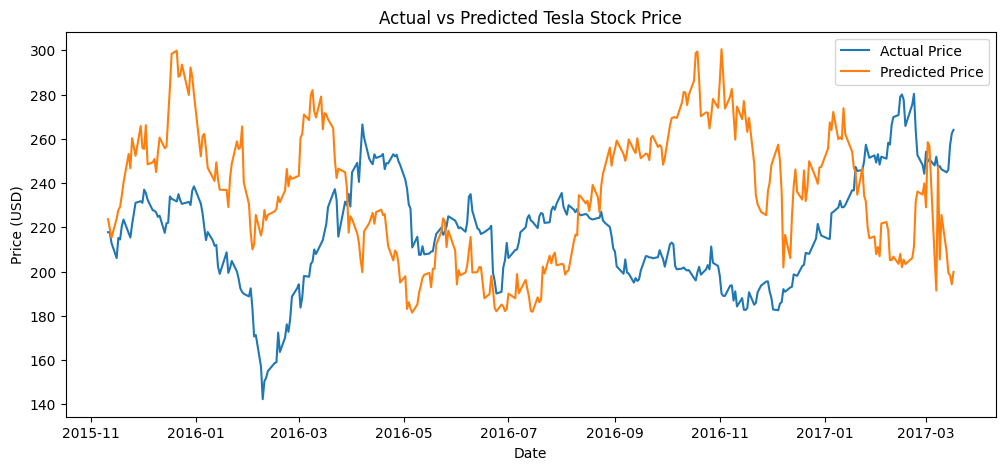

In [15]:
plt.figure(figsize=(12,5))
plt.plot(test['ds'], np.exp(test['y']), label='Actual Price')
plt.plot(test['ds'], forecast['yhat_orig'][-len(test):], label='Predicted Price')
plt.legend()
plt.title("Actual vs Predicted Tesla Stock Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()



In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

train_size = int(len(df) * 0.8)

train = df.iloc[:train_size]
test = df.iloc[train_size:]
def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])

adf_test(train['Close'])


ADF Statistic: -0.7113746502534855
p-value: 0.8437812063571501


Differencing to make data stationary

In [18]:
train_diff = train['Close'].diff().dropna()
test_diff = test['Close'].diff().dropna()

adf_test(train_diff)


ADF Statistic: -36.21458399584532
p-value: 0.0


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1353
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3865.246
Date:                Sat, 03 Jan 2026   AIC                           7742.492
Time:                        14:24:50   BIC                           7773.749
Sample:                             0   HQIC                          7754.197
                               - 1353                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0119      0.018      0.649      0.516      -0.024       0.048
ar.L2         -0.0206      0.022     -0.956      0.339      -0.063       0.022
ar.L3         -0.0295      0.019     -1.590      0.1

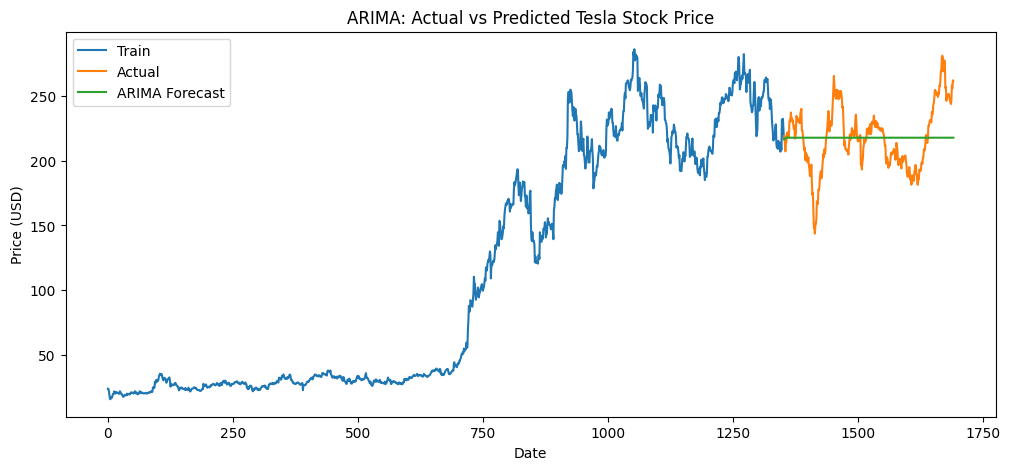

In [19]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train['Close'], order=(5,1,0))
model_fit = model.fit()

print(model_fit.summary())
forecast = model_fit.forecast(steps=len(test))
forecast = pd.Series(forecast, index=test.index)
plt.figure(figsize=(12,5))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Actual')
plt.plot(forecast.index, forecast, label='ARIMA Forecast')
plt.legend()
plt.title("ARIMA: Actual vs Predicted Tesla Stock Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()
